In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from mlxtend.classifier import StackingCVClassifier

from sklearn.preprocessing import Binarizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score,roc_auc_score
from sklearn.metrics import precision_recall_curve,roc_curve,confusion_matrix , auc
from sklearn.model_selection import KFold, StratifiedKFold,cross_val_score

from sklearn.pipeline import Pipeline,make_pipeline


model_LR=LogisticRegression(C=1,max_iter=100,penalty='l2',solver='lbfgs',random_state=1,l1_ratio=0.5)
model_lda=LinearDiscriminantAnalysis(priors=[0.9669206094627105, 0.0330793905372895], solver='lsqr')
model_NB = GaussianNB(priors=[0.9669206094627105, 0.0330793905372895])
model_RF = RandomForestClassifier(random_state=1,class_weight=None, max_depth=10, min_samples_leaf= 1, min_samples_split= 5, n_estimators= 50)
model_XGB = XGBClassifier(random_state=1,class_weight='balanced_subsample', colsample_bytree= 0.9, gamma= 0, learning_rate= 0.001, max_depth=15, min_child_weight= 1, n_estimators= 100, subsample= 0.9)

In [10]:
## 불균형 처리 안한 데이터 
train = pd.read_csv("./datasets/통계검증완료/코스닥_standard_train.csv",index_col=0)
test =  pd.read_csv("./datasets/통계검증완료/코스닥_standard_test.csv",index_col=0)

id_col = ['회사명', '거래소코드', '회계년도', '산업군','target_3']


최종_col_3 = ['abs(영업현금흐름-당기순이익)/매출액', '누적수익성비율', 'WW지수','금융비용부담률', 'TMD', '순운전자본비율']

X_train = train[최종_col_3]
y_train = train["target_3"]

X_test = test[최종_col_3]
y_test = test["target_3"]

In [11]:
X_train_re = X_train.copy()
X_test_re = X_test.copy()

X_train_re.columns = list(range(1,len(X_train.columns)+1))
X_test_re.columns = list(range(1,len(X_train.columns)+1))

In [12]:
# 개별모델 내부에서 CV 적용해 Stacking하는 함수 구현(k=5)
def get_stacking_datasets(model):

    # 최종 메타 모델이 사용할 학습 데이터 반환을 위해서 넘파이 배열을 0으로 만들어서 초기화
    train_fold_pred = np.zeros((X_train_re.shape[0], 1)) # 2차원으로
    test_pred = np.zeros((X_test_re.shape[0], 5)) # n_splits=5
    print(model.__class__.__name__, '모델 시작')
    
    for folder_counter, (train_idx, valid_idx) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(X_train_re)):
        # 개별 모델 내부에서 학습하고 1개의 fold로 예측할 데이터 셋 추출
        print(f" Fold 횟수 : {folder_counter+1}")
        X_train_ = X_train_re.iloc[train_idx]
        y_train_ = y_train.iloc[train_idx]
        X_test_ = X_train_re.iloc[valid_idx]
        
        # 개별 모델이 학습한 후 1개의 fold데이터셋으로 예측값 반환 후 최종 메타모델이 학습할 데이터셋에 첨가
        model.fit(X_train_, y_train_)
        train_fold_pred[valid_idx, :] = model.predict(X_test_).reshape(-1,1)
        # 개별 모델이 원본 데이터셋의 검증 데이터셋을 기반으로 예측 결과값 반환 후 최종 메타모델이 검증할 데이터셋에 첨가
        test_pred[:, folder_counter] = model.predict(X_test_re)
    
    # 개별모델안에서 테스트 데이터셋을 기반으로 예측한 결과값들 mean취해주고 2차원으로 바꾸어주기
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean

In [13]:
def eval(test,pred):
    acc = accuracy_score(test,pred)
    f1 = f1_score(test,pred)
    precision = precision_score(test,pred)
    recall = recall_score(test,pred)
    print('##############\n',confusion_matrix(test,pred),
    "############\n",f'acc_score: {acc}\n f1_score: {f1} \n precision: {precision} \n recall: {recall}')

## 임계값 =[] 리스트생성 후 for 구문
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds=[0.5,0.52,0.54,0.56,0.58,0.6,0.62]):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        eval(y_test , custom_predict)


def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

## roc curve_plot    
def roc_curve_plot(y_test,pred_proba):
    fprs, tprs, thresholds = roc_curve(y_test,pred_proba) ## 입력시 1레이블 컬럼만 추출
    
    # Roc curve를 plot 곡선으로 기름
    plt.plot(fprs,tprs,label='ROC')
    ## 가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1],"k--",label="ramdom")
    
    ## fpr x축을 scale을 0.1단위로 변경 x,y축 명 설정
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR(1-sensitivity)')
    plt.ylabel('TPR(recall)')
    plt.legend()
    plt.show()

In [14]:
def plot_pr_auc_curve(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    # Plot the PR-AUC curve
    plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-AUC Curve')
    plt.legend()
    plt.show()

def get_pr_auc_score(y_true, y_pred_proba):
    # Calculate precision, recall and threshold values
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Calculate PR-AUC score
    pr_auc = auc(recall, precision)
    return pr_auc

------------------------
# 스태킹 라이브러리

In [21]:
sclf = StackingCVClassifier(classifiers=[model_lda, model_NB, model_RF,model_XGB], meta_classifier=model_LR, use_probas=True, cv=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# Do CV
for clf, label in zip([model_lda, model_NB, model_RF,model_XGB, sclf], 
                      ['LDA', 
                       'Naive Bayes',
                       'Random Forest', 
                       'XGBClassifier',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1')
    print("f1_score: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

# Fit on train data / predict on test data
sclf_fit = sclf.fit(X_train, y_train)
mypreds = sclf_fit.predict_proba(X_test)
# "predict" delivers classes, "predict_proba" delivers probabilities

# Probabilities for classes (1,0)
zeros = [i[0] for i in mypreds]
ones  = [i[1] for i in mypreds]

# Get IDs and predictions
y_id = test[['회사명']].values.tolist()
회계년도 = test[['회계년도']].values.tolist()
preddf = pd.DataFrame({'ID_code': y_id,'회계년도':회계년도,'target': ones})
preddf['ID_code'] = preddf['ID_code'].map(lambda x: str(x)[:-2])
preddf['ID_code'] = preddf['ID_code'].map(lambda x: str(x)[2:])

# Look at predictions
print(preddf.head())



f1_score: 0.59 (+/- 0.04) [LDA]
f1_score: 0.56 (+/- 0.02) [Naive Bayes]
f1_score: 0.66 (+/- 0.04) [Random Forest]
[11:28:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:28:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:28:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:28:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:28:58] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscalin

c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[11:29:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:07] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are n

c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[11:29:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are n

c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[11:29:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are n

c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[11:29:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:23] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are n

c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


f1_score: 0.67 (+/- 0.05) [StackingClassifier]
[11:29:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.

[11:29:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learne

c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


In [22]:
preddf['회계년도'] = test['회계년도']
preddf['실제값'] = test['target_3']
pred_prob = pd.array(preddf['target'])
pred_prob = pred_prob.reshape(-1,1)

Text(50.722222222222214, 0.5, 'Actual')

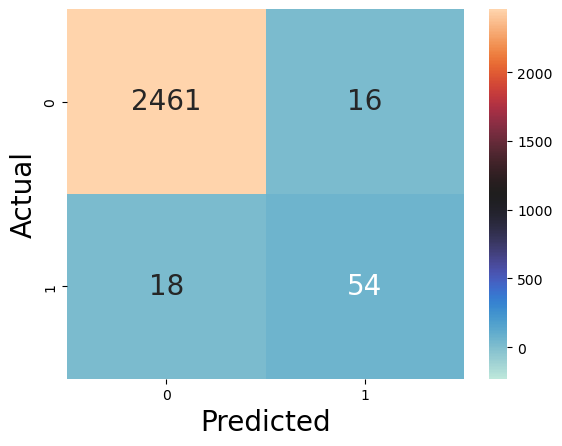

In [23]:
binarizer = Binarizer(threshold=0.41).fit(pred_prob) 
custom_rf = binarizer.transform(pred_prob)
cm = confusion_matrix(y_test, custom_rf)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap="icefire", fmt='g',vmin=-230)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

In [24]:
eval(y_test,custom_rf)

##############
 [[2461   16]
 [  18   54]] ############
 acc_score: 0.9866614358571989
 f1_score: 0.7605633802816902 
 precision: 0.7714285714285715 
 recall: 0.75


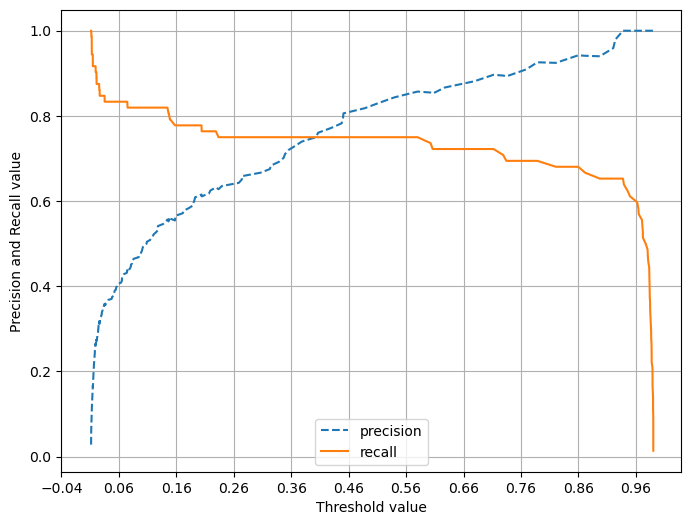

In [25]:
precision_recall_curve_plot(y_test,pred_prob)

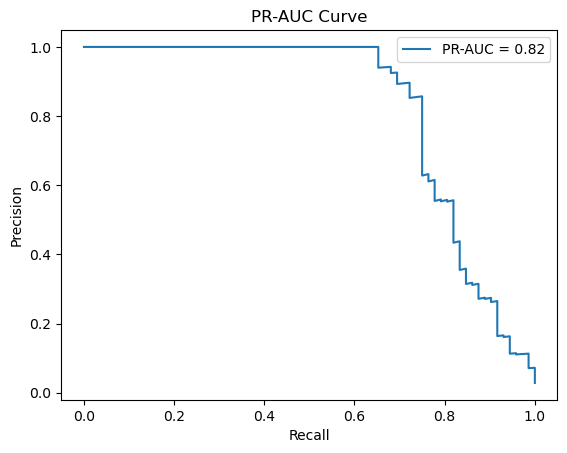

0.8219970702543471

In [26]:
plot_pr_auc_curve(y_test,pred_prob)
get_pr_auc_score(y_test,pred_prob)

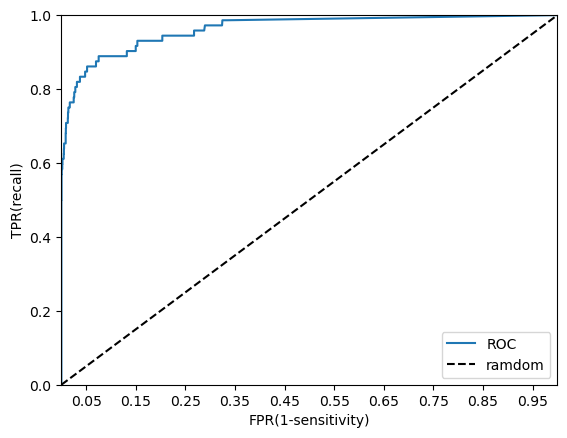

0.9626118300183721

In [71]:
roc_curve_plot(y_test,pred_prob)
roc_auc_score(y_test,pred_prob)